<a href="https://colab.research.google.com/github/karencfisher/Hotel-Cancellations/blob/master/notebooks/Hotel_XGBOOST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install category_encoders==2.*
!pip install eli5

!wget https://raw.githubusercontent.com/karencfisher/Hotel-Cancellations/master/tools.py

     |████████████████████████████████| 81kB 4.4MB/s 
     |████████████████████████████████| 112kB 7.1MB/s 
--2020-06-11 17:33:37--  https://raw.githubusercontent.com/karencfisher/Hotel-Cancellations/master/tools.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8853 (8.6K) [text/plain]
Saving to: ‘tools.py’

tools.py            100%[===================>]   8.65K  --.-KB/s    in 0s      

2020-06-11 17:33:37 (73.8 MB/s) - ‘tools.py’ saved [8853/8853]



## Model implemented with XGBOOST



In [ ]:


import tools
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np

import category_encoders as ce

from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline as make_imb_pipeline

import eli5
from eli5.sklearn import PermutationImportance

# Load dataset
url = 'https://raw.githubusercontent.com/karencfisher/Hotel-Cancellations/master/hotel_bookings.csv'
df = pd.read_csv(url)

# Correct some target values -- should be 'no-show' or 'cancellation' when checkout and
# arrival dates same indicating no stay
df = tools.fixTarget(df)

# Prepare training, validation, and test sets
X = df.drop('reservation_status', axis=1)
y= df['reservation_status']

# Convert output to binary classes, true (cancelled), false (check-out)
y = y != 'Check-Out'

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=42,
                                                    stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=.3,
                                                  random_state=42, stratify=y_train)

### Taking a look at the data set, as it will be processed by the model

In [ ]:
tools.wrangleData(max_cardinality=50).transform(X_train).sample(10)

,hotel,lead_time,arrival_date_week_number,adults,meal,market_segment,is_repeated_guest,previous_cancellations,booking_changes,deposit_type,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,nights_stay,room_type_changed
72525,City Hotel,11,31,2.0,BB,Online TA,0,0,0,No Deposit,0,Transient,129.0,0,2,1.0,False
109099,City Hotel,68,14,1.0,BB,Groups,0,0,0,No Deposit,0,Transient-Party,100.0,0,0,2.0,False
32055,Resort Hotel,30,2,2.0,BB,Online TA,0,0,0,No Deposit,0,Transient,58.0,0,1,2.0,False
97822,City Hotel,4,39,1.0,BB,Aviation,0,0,2,No Deposit,0,Transient,95.0,0,0,2.0,True
96823,City Hotel,11,37,2.0,BB,Online TA,0,0,0,No Deposit,0,Transient,148.0,1,1,4.0,False
93514,City Hotel,36,30,2.0,BB,Online TA,0,0,0,No Deposit,0,Transient,216.9,1,2,1.0,False
111422,City Hotel,34,19,1.0,BB,Groups,0,0,2,No Deposit,0,Transient-Party,130.0,0,1,2.0,False
46800,City Hotel,151,4,1.0,BB,Offline TA/TO,0,0,1,No Deposit,63,Transient-Party,71.0,0,0,3.0,False
24676,Resort Hotel,0,23,2.0,BB,Offline TA/TO,0,0,0,No Deposit,0,Group,NaN,0,0,1.0,False
79654,City Hotel,16,44,2.0,BB,Online TA,0,0,0,No Deposit,0,Contract,95.0,0,1,1.0,False


In [ ]:
y_train.value_counts()

False    36485
True     22016
Name: reservation_status, dtype: int64

In [ ]:
from sklearn.utils import compute_class_weight
weights = compute_class_weight('balanced', y_train.unique(), y_train)
weights

array([0.80171303, 1.32860193])

### Undersampling the majority class

In [ ]:
from imblearn.under_sampling import RandomUnderSampler


### Initial application of the model

In [ ]:

from xgboost import XGBClassifier

xg_pipeline = make_imb_pipeline(tools.wrangleData(max_cardinality=50),
                            ce.OrdinalEncoder(),
                            SimpleImputer(),
                            RandomUnderSampler(),
                            XGBClassifier(random_state=42,
                                          n_estimators=1500,
                                          max_depth=5,
                                          learning_rate=0.25,
                                          n_jobs=-1))

tools.tryModel(xg_pipeline, X_train, y_train, X_val, y_val)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)




Train score = 92.22919266337327 %
Validate score = 83.66703892788769 %




'Confusion Matrix'

,False,True
False,13174,2463
True,1632,7803


'Metrics'

,precision,recall,f1-score
False,0.889774,0.842489,0.865486
True,0.760082,0.827027,0.792143


### Further hyperparameter tuning using randomized search

In [ ]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [ ]:
xg_pipeline1 = make_imb_pipeline(tools.wrangleData(max_cardinality=50),
                            ce.OrdinalEncoder(),
                            SimpleImputer(),
                            RandomUnderSampler(),
                            XGBClassifier(random_state=42,
                                          n_jobs=-1))

params = {"xgbclassifier__learning_rate"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ] ,
          "xgbclassifier__max_depth"        : [ 3, 4, 5, 6, 8, 10, 12, 15],
          "xgbclassifier__min_child_weight" : [ 1, 3, 5, 7 ],
          "xgbclassifier__gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
          "xgbclassifier__colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ],
          "xgbclassifier__max_leaves"       : [0, 2, 4, 8, 10]}

search = RandomizedSearchCV(xg_pipeline1, params, n_iter=100, scoring='recall', n_jobs=-1,
                            random_state=42, verbose=10, cv=3)
search.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   11.4s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   20.2s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   34.8s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   58.2s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done 109 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:  6.7min
[Parallel(n_jobs=-1)]: Done 141 tasks      | elapsed:  7

RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('wrangledata',
                                              wrangleData(max_cardinality=50,
                                                          remove_dates=True)),
                                             ('ordinalencoder',
                                              OrdinalEncoder(cols=None,
                                                             drop_invariant=False,
                                                             handle_missing='value',
                                                             handle_unknown='value',
                                                             mapping=None,
                                                             return_df=True,
                                                             verbose=0)),
                                             ('simpleimputer',
           

In [ ]:
search.best_params_

{'xgbclassifier__colsample_bytree': 0.7,
 'xgbclassifier__gamma': 0.3,
 'xgbclassifier__learning_rate': 0.2,
 'xgbclassifier__max_depth': 15,
 'xgbclassifier__max_leaves': 8,
 'xgbclassifier__min_child_weight': 1}

In [ ]:
search.best_score_

0.8201979253606773

### Apply results from the randomized search

I manually har code the selected parameters, as otherwise when reopening the notebook it is necessary to rerun the search, which is time intensive. There is some improvement.

In [ ]:
xg_pipeline2 = make_imb_pipeline(tools.wrangleData(max_cardinality=50),
                            ce.OrdinalEncoder(),
                            SimpleImputer(),
                            RandomUnderSampler(random_state=42),
                            XGBClassifier(random_state=42,
                                          n_jobs=-1,
                                          colsample_bytree=0.7,
                                          gamma=0.3,
                                          learning_rate=0.2,
                                          max_depth=15,
                                          max_leaves=8,
                                          min_child_weight=1))

tools.tryModel(xg_pipeline2, X_train, y_train, X_val, y_val)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)




Train score = 93.6257499871797 %
Validate score = 84.09779834077857 %




'Confusion Matrix'

,False,True
False,13250,2387
True,1600,7835


'Metrics'

,precision,recall,f1-score
False,0.892256,0.847349,0.869223
True,0.766484,0.830419,0.797171


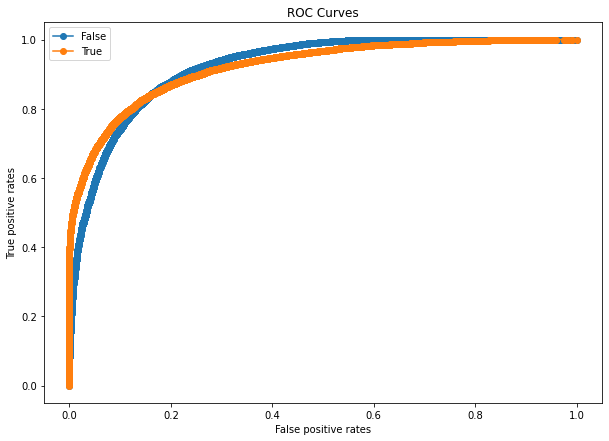

In [ ]:
model = xg_pipeline2.named_steps['xgbclassifier']
wrang = xg_pipeline2.named_steps['wrangledata']
tools.ROCcurves(y_val, X_val, xg_pipeline2, classes=model.classes_)

### Default feature importances

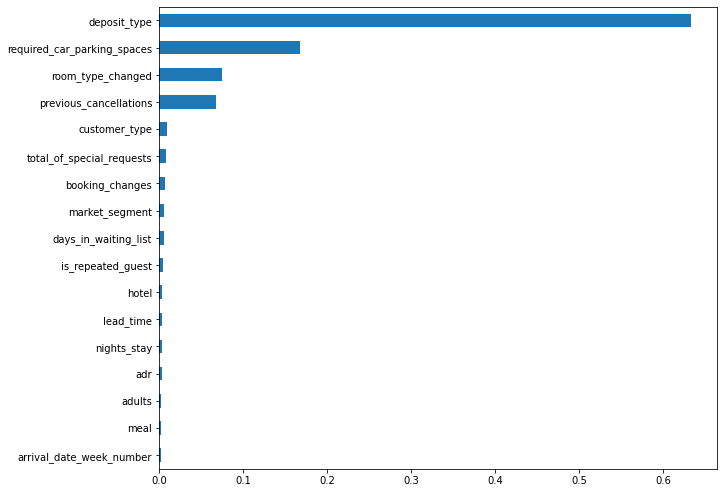

In [ ]:
import matplotlib.pyplot as plt

importances = pd.Series(model.feature_importances_, wrang.columns_)
plt.figure(figsize=(10, len(wrang.columns_) / 2))
importances.sort_values().plot.barh();

### Permutation feature importances

Here I looked at them both in terms of accuracy score and recall.

In [ ]:
def permutationImports(model):
    # Pipeline for transformers alone
    transformers = make_pipeline(tools.wrangleData(max_cardinality=50),
                                ce.OrdinalEncoder(),
                                SimpleImputer())

    X_train_transformed = transformers.fit_transform(X_train)
    X_train_resample, y_train_resample = RandomUnderSampler(random_state=42).fit_sample(X_train_transformed, y_train)
    X_val_transformed = transformers.transform(X_val)

    # fit the  model
    model.fit(X_train_resample, y_train_resample)

    # We'll look at the importances for both accuracy score and recall
    permuter = PermutationImportance(
        model,
        scoring='accuracy',
        random_state=42
    )

    permuter1 = PermutationImportance(
        model,
        scoring='recall',
        random_state=42
    )

    permuter.fit(X_val_transformed, y_val)
    permuter1.fit(X_val_transformed, y_val)

    wrangler = transformers.named_steps['wrangledata']

    print('Accuracy score\n')
    permute_scores = pd.Series(permuter.feature_importances_, wrangler.columns_)
    display(permute_scores.sort_values(ascending=False))
    print('\n')

    plt.figure(figsize=(10, len(wrangler.columns_) / 2))
    permute_scores.sort_values().plot.barh()
    plt.show()

    print('\nRecall scores\n')
    permute1_scores = pd.Series(permuter1.feature_importances_, wrangler.columns_)
    display(permute1_scores.sort_values(ascending=False))
    print('\n')

    plt.figure(figsize=(10, len(wrangler.columns_) / 2))
    permute1_scores.sort_values().plot.barh()
    plt.show()

    return permute_scores, permute1_scores

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Accuracy score



deposit_type                   0.076683
lead_time                      0.063481
total_of_special_requests      0.052951
market_segment                 0.033416
previous_cancellations         0.030480
adr                            0.027250
room_type_changed              0.020788
customer_type                  0.020637
arrival_date_week_number       0.019935
nights_stay                    0.019304
required_car_parking_spaces    0.016752
hotel                          0.011830
booking_changes                0.010187
adults                         0.004882
is_repeated_guest              0.002728
meal                           0.001260
days_in_waiting_list           0.000487
dtype: float64

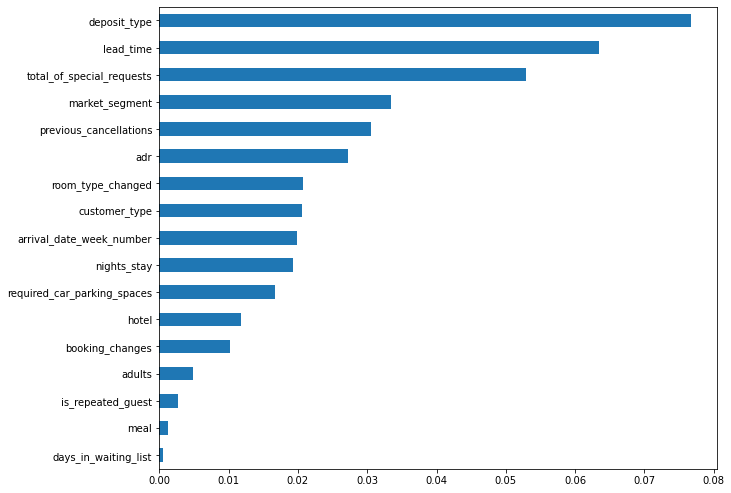


Recall scores



market_segment                 0.098336
lead_time                      0.073047
adr                            0.072496
customer_type                  0.071415
room_type_changed              0.050747
deposit_type                   0.050005
total_of_special_requests      0.041208
arrival_date_week_number       0.031627
required_car_parking_spaces    0.030758
previous_cancellations         0.020901
booking_changes                0.018654
nights_stay                    0.018506
hotel                          0.011214
meal                           0.010620
is_repeated_guest              0.010493
adults                         0.004303
days_in_waiting_list           0.002374
dtype: float64

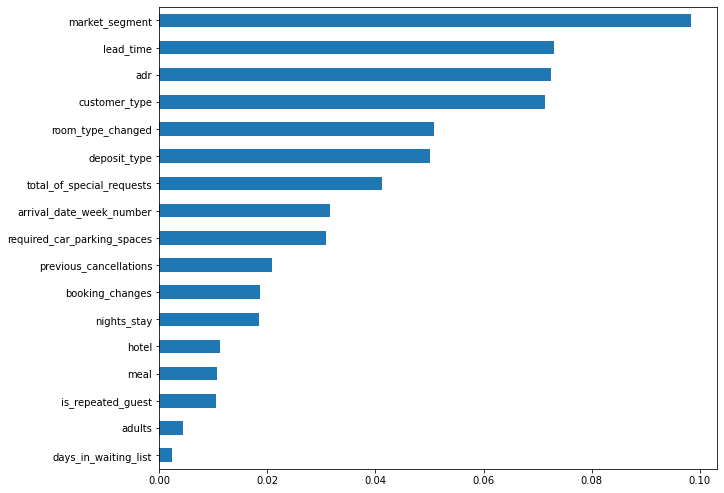

In [ ]:
xg_model = XGBClassifier(random_state=42,
                        n_jobs=-1,
                        colsample_bytree=0.7,
                        gamma=0.3,
                        learning_rate=0.2,
                        max_depth=15,
                        max_leaves=5,
                        min_child_weight=1)

acc_scores, recall_scores = permutationImports(xg_model)

### Run the model on the test set, as a final step (or so I thought)

In [ ]:
y_pred = xg_pipeline2.predict(X_test)

In [ ]:
results = tools.class_metrics(y_test, y_pred)
results[0]

,False,True
False,19022,3316
True,2301,11178


In [ ]:
results[1]

,precision,recall,f1-score
False,0.892088,0.851553,0.871350
True,0.771216,0.829290,0.799199


In [ ]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy = {accuracy * 100} %')

Accuracy = 84.31750286176955 %
